An Ensemble algo where multiple algo are combined & new model are trained upon the error of previous model.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../Reports/50_Startups.csv")

In [7]:
df.dropna(inplace=True)

In [8]:
x = df.drop(columns=["Profit"])
y = df["Profit"]

In [9]:
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV,
    cross_val_score,
    learning_curve,
)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [10]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree  # decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

In [11]:
cross_validation = KFold(n_splits=10, shuffle=True, random_state=1)


def evaluate_decision_tree(x_train, y_train, x, y, cross_validation):
    depths = []
    scores = []
    for depth in range(1, 10):
        tree_regressor = DecisionTreeRegressor(max_depth=depth, random_state=1)
        if tree_regressor.fit(x_train, y_train).tree_.max_depth < depth:
            break
        score = np.mean(
            cross_val_score(
                tree_regressor,
                x,
                y,
                scoring="neg_mean_squared_error",
                cv=cross_validation,
                n_jobs=-1,
            )
        )
        depths.append(depth)
        scores.append(score)
        print(f"Depth: {depth}, Score: {score}")
    return depths, scores

In [12]:
depths, scores = evaluate_decision_tree(x_train, y_train, x, y, cross_validation)

Depth: 1, Score: -676039716.0056016
Depth: 2, Score: -325219073.14620847
Depth: 3, Score: -205813412.95150095
Depth: 4, Score: -229590325.2270043
Depth: 5, Score: -193012985.37454057
Depth: 6, Score: -200124473.9906102
Depth: 7, Score: -212239556.46853048


HyperParameter/External Parameter Tuning:
They are: n_estimators as well as learning_rate


Decision Tree Depth vs. Cross-Validation Score


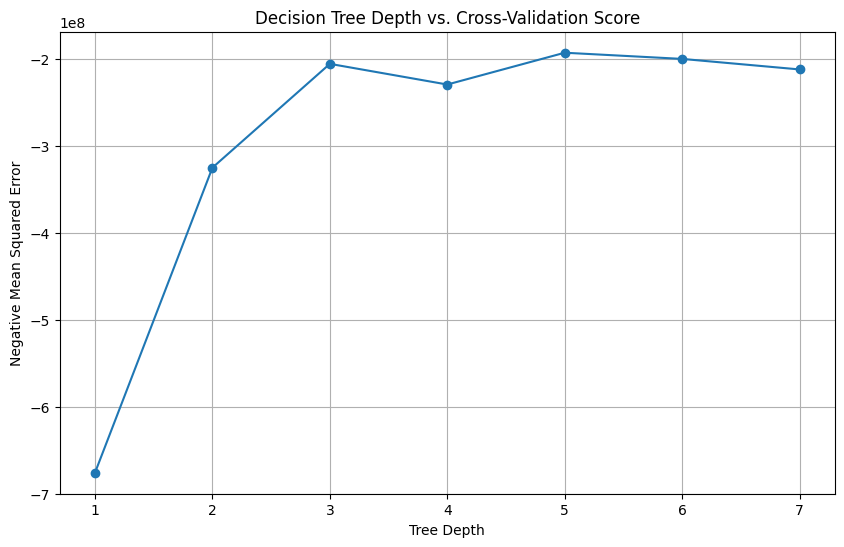

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(depths, scores, marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("Negative Mean Squared Error")
plt.title("Decision Tree Depth vs. Cross-Validation Score")
plt.grid(True)
plt.show()

In [14]:
ad = AdaBoostRegressor(random_state=1)
search_grid = {
    "n_estimators": [500, 1000, 2000],
    "learning_rate": [0.001, 0.01, 0.1],
    "loss": ["linear", "square", "exponential"],
}
search = GridSearchCV(
    estimator=ad,
    param_grid=search_grid,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    cv=cross_validation,
)

In [15]:
search.fit(x, y)
print("Best parameters found: ", search.best_params_)
print("Best cross-validation score: ", search.best_score_)

d:\academics\ML\Exposys\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Best cross-validation score:  -139476101.35977554


Modified HyperParameters:


In [16]:
ad_new = AdaBoostRegressor(
    n_estimators=search.best_params_["n_estimators"],
    learning_rate=search.best_params_["learning_rate"],
    loss=search.best_params_["loss"],
    random_state=1,
)
score = np.mean(
    cross_val_score(
        ad_new,
        x,
        y,
        scoring="neg_mean_squared_error",
        cv=cross_validation,
        n_jobs=1,
    )
)
print("Cross-validation score with the best hyperparameters: ", score)

Cross-validation score with the best hyperparameters:  -139476101.35977554


In [17]:
ad_new.fit(x_train, y_train)

AdaBoostRegressor(learning_rate=0.1, loss='exponential', n_estimators=1000,
                  random_state=1)

In [18]:
y_pred = ad_new.predict(x_test)
test_score = np.mean((y_pred - y_test) ** 2)
print(f"Test set score (MSE): {test_score}")

Test set score (MSE): 77465901.72351572


In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    ad_new,
    x,
    y,
    cv=cross_validation,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

In [20]:
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

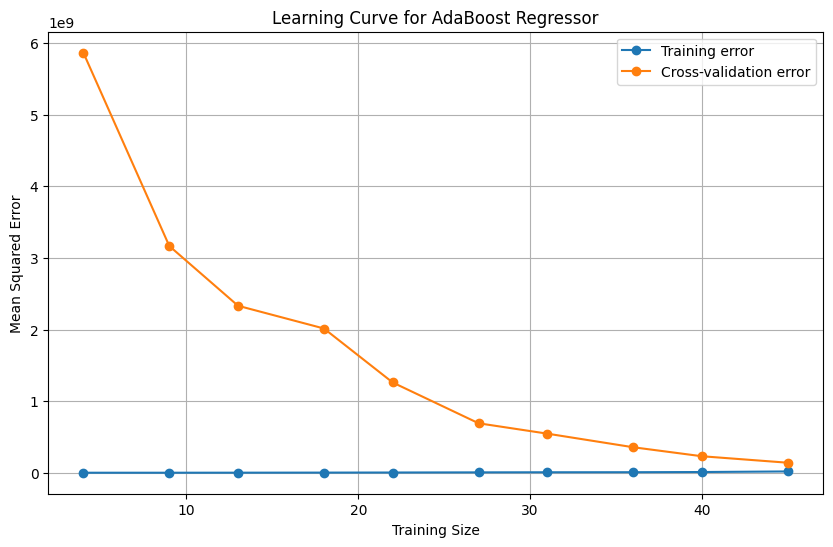

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, "o-", label="Training error")
plt.plot(train_sizes, test_scores_mean, "o-", label="Cross-validation error")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for AdaBoost Regressor")
plt.legend(loc="best")
plt.grid(True)
plt.show()

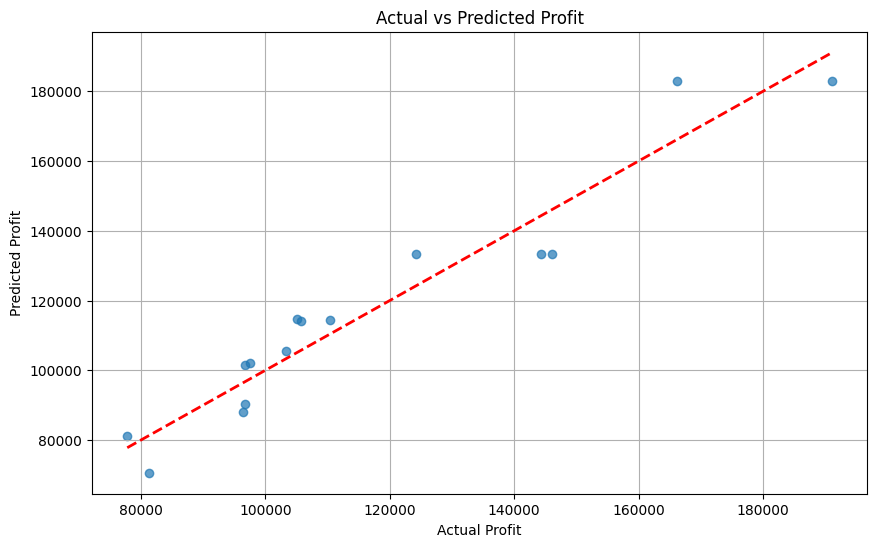

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Actual vs Predicted Profit")
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
mae_test = mean_absolute_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, ad_new.predict(x_train))
print(f"Mean Absolute Error (MAE) on testing set: {mae_test}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train}")

Mean Absolute Error (MAE) on testing set: 7954.251273015876
Mean Absolute Error (MAE) on training set: 3455.6632909780715


In [25]:
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
rmse_train = mean_squared_error(y_train, ad_new.predict(x_train), squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train}")

Root Mean Squared Error (RMSE): 8801.471565796013

d:\academics\ML\Exposys\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\academics\ML\Exposys\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Root Mean Squared Error (RMSE) on training set: 4060.2035041197037


In [26]:
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, ad_new.predict(x_train))
print(f"R² Score: {r2_test}")
print(f"R² Score on training set: {r2_train}")

R² Score: 0.9197450187265491
R² Score on training set: 0.991089523183328


In [27]:
n_test = x_test.shape[0]
p_test = x_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p_test - 1))
print(f"Adjusted R² Score for test set: {adjusted_r2_test}")

Adjusted R² Score: 0.8978572965610625


In [28]:
n_train = x_train.shape[0]
p_train = x_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p_train - 1))
print(f"Adjusted R² Score on training set: {adjusted_r2_train}")

Adjusted R² Score on training set: 0.990227218975263
